In [2]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas import DataFrame

# ADF 테스트 - 정상성 확인용
from statsmodels.tsa.stattools import adfuller
# ACF, PACF 테스트
from statsmodels.tsa.stattools import acf, pacf
# ACF, PACF 시각화 기능
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('air_passengers')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (144, 2)
열 개수: 2
행 개수: 144

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
df1 = origin.set_index('Month')
df1.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


,차수,ADF Statistic,p-value,result
0,0,0.815369,9.918802e-01,False
1,1,-2.829267,5.421329e-02,False
2,2,-16.384232,2.732892e-29,True


,Month,Passengers
2,-3 days,8.0
3,3 days,-17.0
4,-1 days,-5.0
5,1 days,22.0
6,-1 days,-1.0


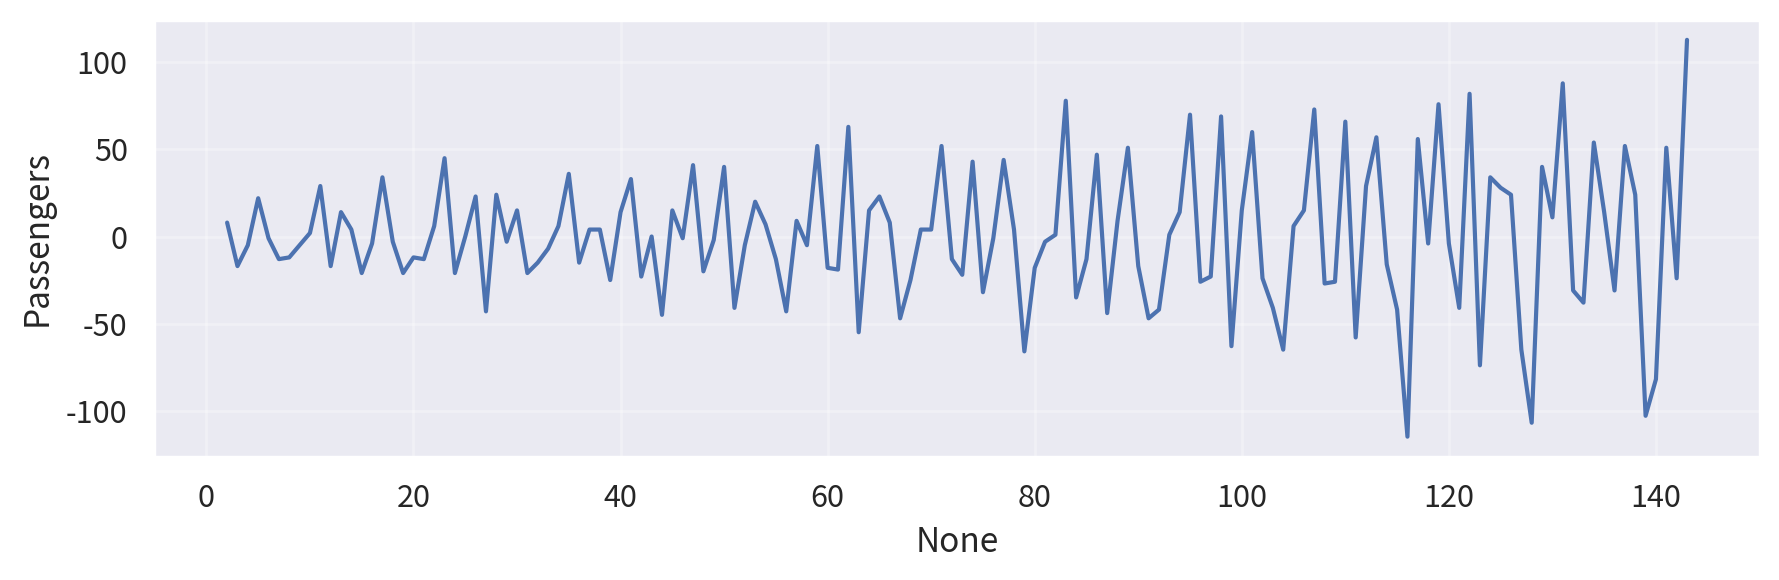

In [7]:
diff_df = origin.copy()
yname = 'Passengers'
diff_count = 0  #몇 번까지 차분을 수행했는지 count
result = []     #결과를 저장할 빈 리스트

while True:
    ar = adfuller(diff_df[yname])
    ar_dict={
        '차수': diff_count,
        'ADF Statistic': ar[0],
        'p-value': ar[1],
        'result' : True if ar[1] <= 0.05 else False
    }

    # 리스트에 정상성 검사 결과를 저장
    result.append(ar_dict)

    # 정상성 충족이라면 반복 중단
    if ar_dict['result']:
        break

    # 정상성이 충족되지 않았다면 차분 수행
    diff_count += 1
    diff_df= diff_df.diff().dropna()

# 차분 결과표
display(DataFrame(result))

# 차분의 결과로 생성된 데이터프레임
display(diff_df.head())

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1800             #그래프 가로 크기
height_px = 600             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
# sb.boxplot(data=df1, orient='h')
sb.lineplot(data=diff_df, x=diff_df.index, y=yname)

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
ax.grid(True, alpha=0.3)          

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

    

In [10]:
# 1. 차분된 시계열의 자기상관계수(ACF) 계산 (lag - 0부터 시작)
acf_vals = acf(diff_df['Passengers'])

# 2. ACF 유의성 판단 기준(근사적 95% 신뢰구간)
threshold = 2/np.sqrt(len(diff_df['Passengers']))

# 3. 임계값을 초과하는 (유의한) lag 인덱스 추출
significant_lags = np.where(np.abs(acf_vals) > threshold)[0]

# 4. 결과 확인
acf_vals , threshold, significant_lags

(array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
         0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
        -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
        -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
        -0.24015233,  0.02613065]),
 np.float64(0.16783627165933782),
 array([ 0,  1,  2,  4,  8, 10, 12, 14, 20]))

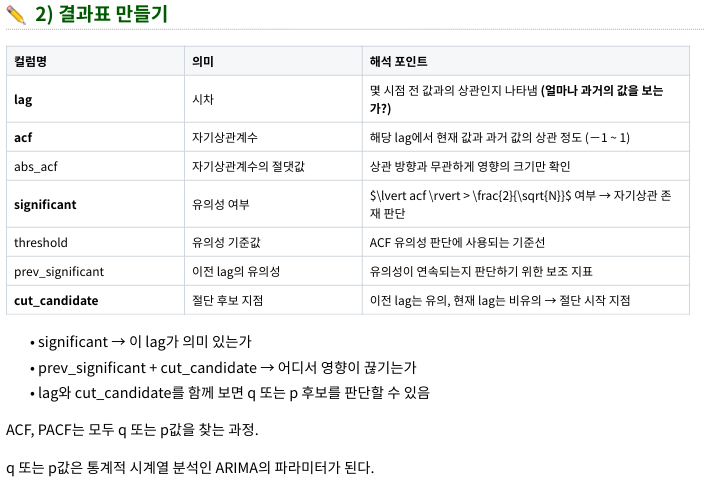

In [11]:
acf_vals = acf(diff_df['Passengers'])

# 2. ACF 유의성 판단 기준(근사적 95% 신뢰구간)
threshold = 2/np.sqrt(len(diff_df['Passengers']))

df_acf = DataFrame({
    'lag': np.arange(len(acf_vals)),
    'acf': acf_vals
})

# 3) 유의성 판단
df_acf['abs_acf'] = df_acf['acf'].abs()
df_acf['significant'] = df_acf['abs_acf'] > threshold

# 4) 보기 좋게 정리
df_acf['acf']= df_acf['acf'].round(3)
df_acf['abs_acf']= df_acf['abs_acf'].round(3)
df_acf['threshold'] = round(threshold, 3)

# 5) lag=0 제외(판정용)
df_acf_result = df_acf.query('lag>0').reset_index(drop=True)

# 6) 연속 유의 구간 계산
df_acf_result['prev_sigificant'] = df_acf_result['significant'].shift(1)

df_acf_result['cut_candidate'] = (
    (df_acf_result['prev_sigificant'] == True) &
    (df_acf_result['significant'] == False)
)

df_acf_result[['lag','acf','significant']]
df_acf_result

,lag,acf,abs_acf,significant,threshold,prev_sigificant,cut_candidate
0,1,-0.191,0.191,True,0.168,NaN,False
1,2,-0.196,0.196,True,0.168,True,False
2,3,-0.049,0.049,False,0.168,True,True
3,4,-0.207,0.207,True,0.168,False,False
4,5,0.119,0.119,False,0.168,True,True
5,6,0.026,0.026,False,0.168,False,False
6,7,0.146,0.146,False,0.168,False,False
7,8,-0.226,0.226,True,0.168,False,False
8,9,0.014,0.014,False,0.168,True,True
9,10,-0.208,0.208,True,0.168,False,False


ACF Plot

In [12]:
q_candidate = (
    df_acf_result.loc[df_acf_result['cut_candidate'], 'lag'].min()-1
)

q_candidate

np.int64(2)

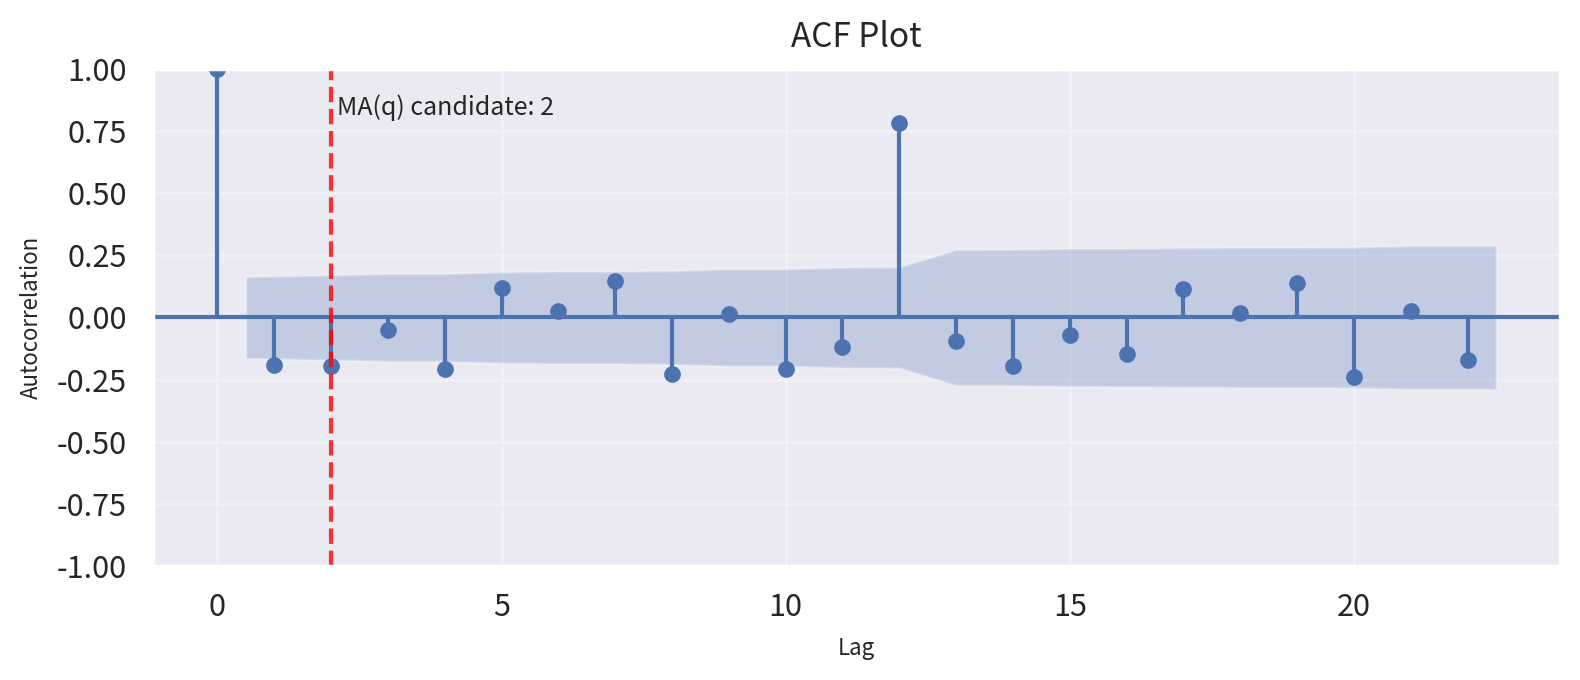

In [13]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600             #그래프 가로 크기
height_px = 700             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

plot_acf(diff_df['Passengers'], ax=ax)

ax.axvline(
    x=q_candidate,
    linestyle='--',
    alpha=0.8,
    linewidth=1.5,
    color='red'
)
ax.text(
    q_candidate+0.1,
    ax.get_ylim()[1]*0.9,
    f'MA(q) candidate: {q_candidate}',
    fontsize=9,
    verticalalignment='top'
)

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
ax.set_title("ACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

PACF 직접 계산하기

In [21]:
pacf_vals = pacf(diff_df['Passengers'])
threshold = 2/np.sqrt(len(diff_df['Passengers']))

df_pacf = DataFrame({
    'lag': np.arange(len(pacf_vals)),
    'pacf': pacf_vals
})

df_pacf['abs_pacf'] = df_pacf['pacf'].abs()
df_pacf['significant'] = df_pacf['abs_pacf'] > threshold

df_pacf['pacf']= df_pacf['pacf'].round(3)
df_pacf['abs_pacf']= df_pacf['abs_pacf'].round(3)
df_pacf['threshold'] = round(threshold, 3)

df_pacf_result = df_pacf.query('lag>0').reset_index(drop=True)

df_pacf_result['prev_significant'] = df_pacf_result['significant'].shift(1)

df_pacf_result['cut_candidate'] = (
    (df_pacf_result['prev_significant'] == True) &
    (df_pacf_result['significant'] == False)
)

df_pacf_result[['lag','pacf','significant','cut_candidate']]
df_pacf_result

,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.192,0.192,True,0.168,NaN,False
1,2,-0.245,0.245,True,0.168,True,False
2,3,-0.159,0.159,False,0.168,True,True
3,4,-0.355,0.355,True,0.168,False,False
4,5,-0.112,0.112,False,0.168,True,True
5,6,-0.169,0.169,True,0.168,False,False
6,7,0.078,0.078,False,0.168,True,True
7,8,-0.329,0.329,True,0.168,False,False
8,9,-0.075,0.075,False,0.168,True,True
9,10,-0.596,0.596,True,0.168,False,False


PACF Plot

In [22]:
p_candidate = (
    df_pacf_result.loc[df_pacf_result['cut_candidate'], 'lag'].min()-1
)
p_candidate

np.int64(2)

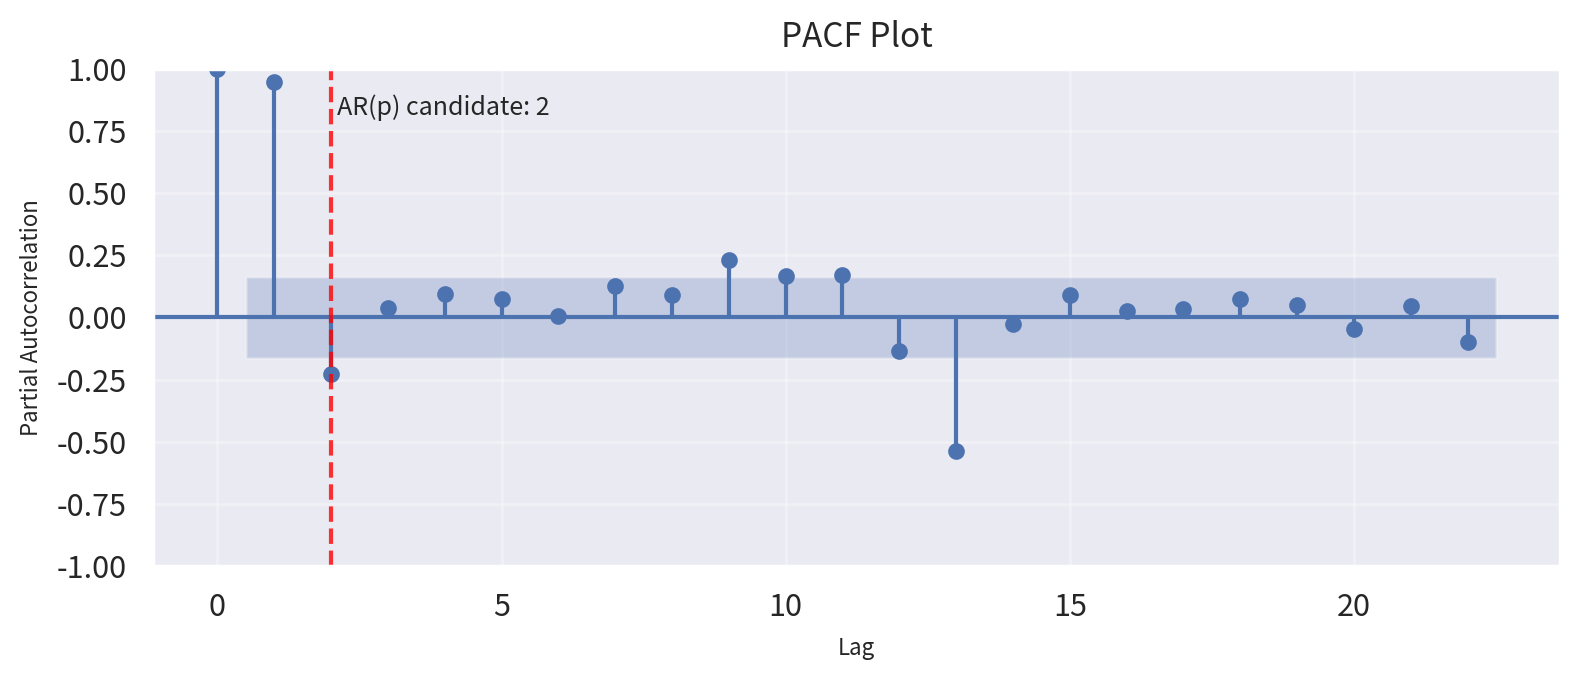

In [26]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600             #그래프 가로 크기
height_px = 700             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

plot_pacf(origin['Passengers'], ax=ax)

ax.axvline(
    x=p_candidate,
    linestyle='--',
    alpha=0.8,
    linewidth=1.5,
    color='red'
)
ax.text(
    p_candidate+0.1,
    ax.get_ylim()[1]*0.9,
    f'AR(p) candidate: {p_candidate}',
    fontsize=9,
    verticalalignment='top'
)

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
ax.set_title("PACF Plot", fontsize=12, pad=8)
ax.set_xlabel("Lag", fontsize=8, labelpad=5)
ax.set_ylabel("Partial Autocorrelation", fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

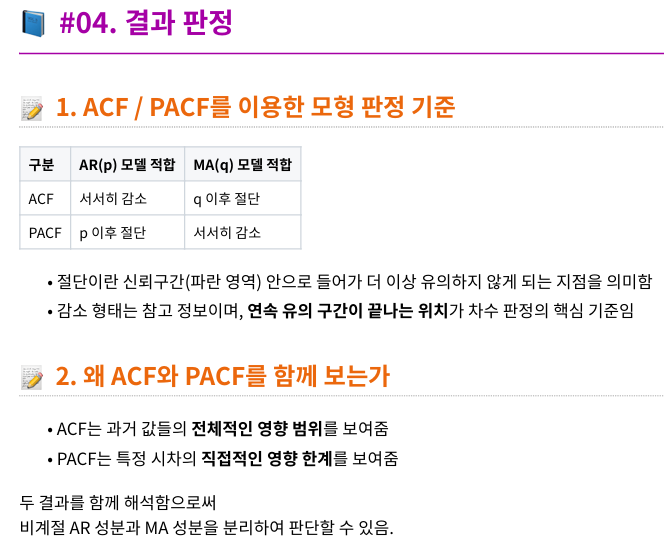

- ACF, PACF 결과 종합
- 차분(d)의 차수를 판단한 뒤,
- 비계절 차수 p<=2, q<=2 범위의 후보를 설정하고,
- ARIMA 모형으로 확장하여 분석하는 것이 타당함.

<!-- # for i in range(0, p+1):
#     for j in range(0, q+1):
#         ARIMA(i,2,j) -->
